In [17]:
import torch
import torch.nn as nn
import gzip, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import pandas as pd

mp.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.dpi'] = 30

In [5]:
dpth = Path('./data/mnist.pkl.gz')
with gzip.open(dpth, 'rb') as f:
    data = pickle.load(f, encoding='latin')
((x_train, y_train), (x_val, y_val), _) = data
(x_train, y_train, x_val, y_val) = map(torch.tensor, (x_train, y_train, x_val, y_val))

In [46]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_val.view(-1, 28, 28)

im3 = x_imgs[7]

top_edge = torch.tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]  
]).float()

df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')


(im3[1:4, 14:17] * top_edge).sum()
(im3[7:10, 14:17] * top_edge).sum()

def apply_kernel(row, col, kernel):
    return (im3[row-1:row+2, col-1:col+2]*kernel).sum()

apply_kernel(8, 15, top_edge)

[[(i, j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

torch.Size([26, 26])

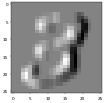

In [69]:
rng = range(1, 27)
top_edge3 = torch.tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
plt.imshow(top_edge3)

left_edge = torch.tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]).float()

left_edge3 = torch.tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
plt.imshow(left_edge3)

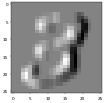

In [76]:
import torch.nn.functional as F

inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3, 3))[0]
inp_unf.shape
torch.Size([9, 676])

w = left_edge.view(-1)
out = (w @ inp_unf).view(26, 26)
plt.imshow(out)

In [86]:
%timeit -n 1 torch.tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])

12.7 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26, 26)

92.3 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
%timeit -n 100 F.conv2d(inp, left_edge[None, None]).shape

67 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


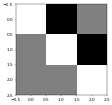

In [96]:
diag1_edge = torch.tensor([
    [0, -1, 1],
    [-1, 1, 0],
    [1, 0, 0]
]).float()
plt.imshow(diag1_edge)

diag2_edge = torch.tensor([
    [1, -1, 0],
    [0, 1, -1],
    [0, 0, 1]
]).float()
plt.imshow(diag2_edge)

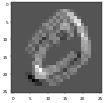

In [113]:
xb = x_imgs[:16][:,None]
torch.Size([16, 1, 28, 28])

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
torch.Size([4, 1, 3, 3])

batch_features = F.conv2d(xb, edge_kernels)
torch.Size([16, 4, 26, 26])

img0 = xb[1,0]
plt.imshow(img0)

plt.imshow(batch_features[1][3])

In [174]:
n,m = x_train.shape
nh = 50
c = y_train.max()+1

model = nn.Sequential(*[nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)])

broken_cnn = nn.Sequential(*[
   nn.Conv2d(1, 30, kernel_size=3, padding=1),
   nn.ReLU(),
   nn.Conv2d(30, 10, kernel_size=3, padding=1)
])
t = broken_cnn(xb)
torch.Size([16, 10, 28, 28])

def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

simple_cnn = nn.Sequential(
    conv(1, 4), #14x14
    conv(4, 8), #7x7
    conv(8, 16), #2x2
    conv(16, 16), #1x1
    conv(16, 10, act=False),
    nn.Flatten()
)
t = simple_cnn(xb)
t.shape

torch.Size([16, 10])